In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Train with Pseudo Labels

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import gc
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import metrics
from scipy.special import softmax

import torch
import torch.nn as nn
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

import pretrainedmodels
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
from radam import RAdam, RAdam_4step
from adamp import AdamP, SGDP

import dataset
import engine
import models
import utils

In [4]:
SEED = 42
utils.seed_everything(SEED)

## Data

In [5]:
device = torch.device("cuda")
df = pd.read_csv("../input/pl3/train_pl3.csv")
df.shape

(15884, 788)

## Train

### Definition

#### Models

In [12]:
def ResNet18(pretrained=None):
    model = pretrainedmodels.__dict__["resnet18"](pretrained=pretrained)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet34(pretrained=None):
    model = pretrainedmodels.__dict__["resnet34"](pretrained=pretrained)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet50(pretrained=None):
    model = pretrainedmodels.__dict__["resnet50"](pretrained=pretrained)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet101(pretrained=None):
    model = pretrainedmodels.__dict__["resnet101"](pretrained=pretrained)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet152(pretrained=None):
    model = pretrainedmodels.__dict__["resnet152"](pretrained=pretrained)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def EfficientNetB1():
    model = EfficientNet.from_name("efficientnet-b1", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32,
        kernel_size=(3, 3),
        stride=(1,1),
        bias=False,
        image_size=(28, 28))
    return model

def EfficientNetB2():
    model = EfficientNet.from_name("efficientnet-b2", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32,
        kernel_size=(3,3),
        stride=(1,1),
        bias=False,
        image_size=(28, 28)
    )
    return model

def EfficientNetB3():
    model = EfficientNet.from_name("efficientnet-b3", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32,
        kernel_size=(3, 3),
        stride=(1, 1),
        bias=False,
        image_size=(28, 28)
    )
    return model

def EfficientNetB4():
    model = EfficientNet.from_name("efficientnet-b4", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 48,
        kernel_size=(3, 3),
        stride=(1, 1),
        bias=False,
        image_size=(28, 28)
    )
    return model

def EfficientNetB5():
    model = EfficientNet.from_name("efficientnet-b5", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32, kernel_size=3, stride=1, bias=False, image_size=(28, 28)
    )
    return model

def EfficientNetB6():
    model = EfficientNet.from_name("efficientnet-b6", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32, kernel_size=3, stride=1, bias=False, image_size=(28, 28)
    )
    return model

def EfficientNetB7():
    model = EfficientNet.from_name("efficientnet-b7", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32, kernel_size=3, stride=1, bias=False, image_size=(28, 28)
    )
    return model

def EfficientNetB8():
    model = EfficientNet.from_name("efficientnet-b8", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32, kernel_size=3, stride=1, bias=False, image_size=(28, 28)
    )
    return model

def EfficientNetL2():
    model = EfficientNet.from_name("efficientnet-l2", image_size=28, num_classes=10)
    model._conv_stem = Conv2dStaticSamePadding(
        3, 32, kernel_size=3, stride=1, bias=False, image_size=(28, 28)
    )
    return model

#### Dispatcher

In [7]:
def get_model(model_name):
    if model_name == "efficientnet-b0":
        return models.EfficientNetB0()
    elif model_name == "efficientnet-b1":
        return EfficientNetB1()
    elif model_name == "efficientnet-b2":
        return EfficientNetB2()
    elif model_name == "efficientnet-b3":
        return EfficientNetB3()
    elif model_name == "efficientnet-b4":
        return EfficientNetB4()
    elif model_name == "efficientnet-b5":
        return EfficientNetB5()
    elif model_name == "efficientnet-b6":
        return EfficientNet61()
    elif model_name == "efficientnet-b7":
        return EfficientNetB7()
    elif model_name == "efficientnet-b8":
        return EfficientNetB8()
    elif model_name == "efficientnet-l2":
        return EfficientNetL2()
    elif model_name == "resnet18":
        return ResNet18()
    elif model_name == "resnet34":
        return ResNet34()
    elif model_name == "resnet50":
        return ResNet50()
    elif model_name == "resnet101":
        return ResNet101()
    elif model_name == "resnet152":
        return ResNet152()
    else:
        raise RuntimeError(f"Unknown model name: {model_name}")

def get_optimizer(optim_name, model, lr, weight_decay=1e-4, skip_list=["bias", "bn"]):
    params = []
    exclude_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        elif any(skip in name for skip in skip_list):
            exclude_params.append(param)
        else:
            params.append(param)
    optim_params = [
        {"params": params, "weight_decay": weight_decay},
        {"params": exclude_params, "weight_decay": 0.0},
    ]
    
    if optim_name == "adam":
        optimizer = torch.optim.Adam(optim_params, lr=lr, betas=(0.9, 0.999))
    if optim_name == "radam":
        optimizer = RAdam(optim_params, lr=lr, betas=(0.9, 0.999))
    elif optim_name == "radam4s":
        optimizer = RAdam_4step(optim_params, lr=lr, betas=(0.9, 0.999))
    elif optim_name == "adamp":
        optimizer = AdamP(optim_params, lr=lr, betas=(0.9, 0.999))
    elif model_name == "sgdp":
        optimizer = SGDP(optim_params, lr=lr, momentum=0.9, nesterov=True)
    else:
        raise RuntimeError(f"Unknown optimizer name: {optim_name}")
        
    return optimizer

#### Train loop function

In [9]:
def run(model_name, optim_name, epochs, lr, checkpoint, swa=False, label_smooth=False):
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))
    
    for fold in range(5):
        train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
        valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=True)
        valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1024)

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr)
#         scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[81, 122], gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        train_accuracies = []
        valid_accuracies = []
        best_accuracy = 0
        checkpoint = Path(checkpoint)
        if not checkpoint.exists(): checkpoint.mkdir(parents=True)
        
        # SWA Model
        if swa:
            swa_start = int(0.75 * EPOCHS)
            swa_model = AveragedModel(model)
            swa_scheduler = SWALR(optimizer, swa_lr=lr * (0.1)**2)

        for epoch in range(epochs):

            # Train
            train_loss, train_accuracy = engine.train(train_loader, model, optimizer, device, scaler, label_smooth=label_smooth)
            train_accuracies.append(train_accuracy)

            # Validate
            valid_probs, valid_targs, valid_loss = engine.evaluate(valid_loader, model, device)
            valid_preds = np.argmax(valid_probs, axis=1)
            valid_accuracy = metrics.accuracy_score(valid_targs, valid_preds)
            valid_accuracies.append(valid_accuracy)

            if swa and swa_start > epoch:
                swa_model.update_parameters(model)
                swa_scheduler.step()
            else:
                scheduler.step()

            # Checkpoint
            is_best = best_accuracy > best_accuracy
            if is_best:
                best_accuracy = valid_accuracy
            if swa:
                utils.save_checkpoint({
                    "epoch": epoch,
                    "state_dict": model.state_dict(),
                    "swa_state_dict": swa_model.state_dict(),
                    "acc": valid_accuracy,
                    "best_acc": best_accuracy,
                    "optimizer": optimizer.state_dict(),
                    }, is_best, checkpoint,
                    filename=f"checkpoint_e{epoch}_top1_{train_accuracy:.3f}_{valid_accuracy:.3f}.pth",
                )
            else:
                utils.save_checkpoint({
                    "epoch": epoch,
                    "state_dict": model.state_dict(),
                    "acc": valid_accuracy,
                    "best_acc": best_accuracy,
                    "optimizer": optimizer.state_dict(),
                    }, is_best, checkpoint,
                    filename=f"checkpoint_e{epoch}_top1_{train_accuracy:.3f}_{valid_accuracy:.3f}.pth",
                )
                
            if epoch % 10 == 0:
                print(f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}")

        # Update BN stats
        if swa:
            swa_model = swa_model.cpu()
            update_bn(train_loader, swa_model)
            swa_model.to(device)

        # Validation
        if swa:
            valid_probs, valid_targs, valid_loss = engine.evaluate(valid_loader, swa_model, device)
        else:
            valid_probs, valid_targs, valid_loss = engine.evaluate(valid_loader, model, device)
        valid_preds = np.argmax(valid_probs, axis=1)
        valid_accuracy = metrics.accuracy_score(valid_targs, valid_preds)
        print(f"Fold={fold}, Validation Accuracy={valid_accuracy}")

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.xlabel("Accuracy")
        plt.ylabel("Epoch")
        plt.legend()
        plt.show()

        # oof prediction
        oof[valid_indices] = softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs
        
        if swa:
            torch.save(swa_model.state_dict(), f"../models/swa-{model_name}-{fold}.pth")
        else:
            torch.save(model.state_dict(), f"../models/{model_name}-{fold}.pth")

        # Cleanup
        del model
        torch.cuda.empty_cache()
        gc.collect()

    if swa:
        np.save(f"../input/processed/oof-train-swa-{model_name}", oof)
    else:
        np.save(f"../input/processed/oof-train-{model_name}", oof)

    return oof, targs

### Baseline

In [ ]:
# Baseline
EPOCHS = 200
oof = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))
SWA = False

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = models.Model().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    # SWA
    if SWA:
        swa_start = int(0.75 * EPOCHS)
        swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        swa_model = AveragedModel(model).to(device)
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler, clip_grad=False)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        if SWA and epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")
    
    if SWA:
        # Update BN-statistics
        swa_model = swa_model.cpu()
        update_bn(train_loader, swa_model)
        swa_model.to(device)
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, swa_model if SWA else model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()

    oof[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(swa_model.state_dict(), f"../models/baseline-swa{SWA}-{fold}.pth")
    
    del model
    torch.cuda.empty_cache()
    gc.collect()

np.save("../input/processed/oof-train-baseline-swa{SWA}", oof)
np.save("../input/processed/targs-train-oof", targs_oof)

In [ ]:
# oof = np.load("../input/processed/oof-train-baseline-swa.npy")
# targs_oof = np.load("../input/processed/targs-train-oof.npy")
preds_oof = np.argmax(oof, axis=1)
accuracy_oof = metrics.accuracy_score(targs_oof, preds_oof)
print(f"CV Accuracy Score={accuracy_oof}")

In [ ]:
EXP = -0.9
s = pd.Series(preds_oof)
vc = s.value_counts().sort_index()
mat = np.diag(vc.astype(np.float32) ** (EXP))

probs_oof_post = oof.dot(mat)
preds_oof_post = np.argmax(probs_oof_post, axis=1)
print(f"Post-processing CV Accuracy score={metrics.accuracy_score(targs_oof, preds_oof_post)}")

### SpinalVGG

In [ ]:
# SpinalVGG
EPOCHS = 200
oof_spinalvgg = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))
SWA = False

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = models.SpinalVGG().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    # SWA
    if SWA:
        swa_start = int(0.75 * EPOCHS)
        swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        swa_model = AveragedModel(model).to(device)
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        if SWA and epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        
        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")

    if SWA:
        # Update BN-stats
        swa_model = swa_model.cpu()
        update_bn(train_loader, swa_model)
        swa_model.to(device)
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, swa_model if SWA else model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
            
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()        
    
    oof_spinalvgg[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(swa_model.state_dict(), f"../models/spinalvgg-swa{SWA}-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
np.save("../input/processed/oof-train-spinalvgg-swa{SWA}", oof2)

In [ ]:
# oof2 = np.load("../input/processed/oof-train-spinalvgg-swa.npy")
# targs_oof2 = np.load("../input/processed/targs-train-oof.npy")
preds_oof2 = np.argmax(oof2, axis=1)
accuracy_oof2 = metrics.accuracy_score(targs_oof2, preds_oof2)
print(f"CV Accuracy Score={accuracy_oof2}")

### ResNet

#### ResNet18

In [ ]:
# Training Parameters
lr = 0.1
epochs = 100
model_name = "resnet18"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=False)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [17]:
torch.cuda.empty_cache()
gc.collect()

56

#### ResNet34

Epoch=0, Train loss=2.67345, Valid loss=144.28108, Train Accuracy=0.18777, Validation Accuracy=0.09034
Epoch=10, Train loss=0.07624, Valid loss=0.28202, Train Accuracy=0.97474, Validation Accuracy=0.92540
Epoch=20, Train loss=0.05204, Valid loss=0.13827, Train Accuracy=0.98332, Validation Accuracy=0.96664
Epoch=30, Train loss=0.00697, Valid loss=0.10813, Train Accuracy=0.99788, Validation Accuracy=0.97482
Epoch=40, Train loss=0.01404, Valid loss=0.13891, Train Accuracy=0.99551, Validation Accuracy=0.97136
Epoch=50, Train loss=0.01219, Valid loss=0.10488, Train Accuracy=0.99622, Validation Accuracy=0.97923
Epoch=60, Train loss=0.00002, Valid loss=0.07495, Train Accuracy=1.00000, Validation Accuracy=0.98552
Epoch=70, Train loss=0.00001, Valid loss=0.07657, Train Accuracy=1.00000, Validation Accuracy=0.98615
Epoch=80, Train loss=0.00001, Valid loss=0.07698, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=90, Train loss=0.00001, Valid loss=0.07906, Train Accuracy=1.00000, Validat

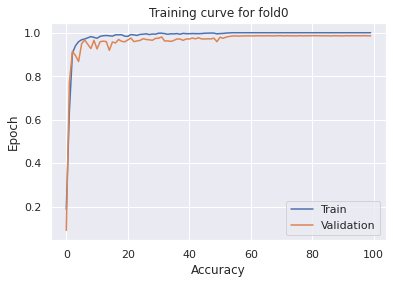

Epoch=0, Train loss=3.04400, Valid loss=2.14882, Train Accuracy=0.19690, Validation Accuracy=0.30469
Epoch=10, Train loss=0.92024, Valid loss=2476.44018, Train Accuracy=0.74660, Validation Accuracy=0.09097
Epoch=20, Train loss=0.07907, Valid loss=0.16119, Train Accuracy=0.97183, Validation Accuracy=0.94932
Epoch=30, Train loss=0.03985, Valid loss=0.09930, Train Accuracy=0.98662, Validation Accuracy=0.97104
Epoch=40, Train loss=0.01242, Valid loss=0.12876, Train Accuracy=0.99614, Validation Accuracy=0.96852
Epoch=50, Train loss=0.01379, Valid loss=0.12985, Train Accuracy=0.99512, Validation Accuracy=0.97325
Epoch=60, Train loss=0.00005, Valid loss=0.08008, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=70, Train loss=0.00004, Valid loss=0.07848, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=80, Train loss=0.00002, Valid loss=0.08111, Train Accuracy=1.00000, Validation Accuracy=0.98426
Epoch=90, Train loss=0.00003, Valid loss=0.08702, Train Accuracy=1.00000, Valida

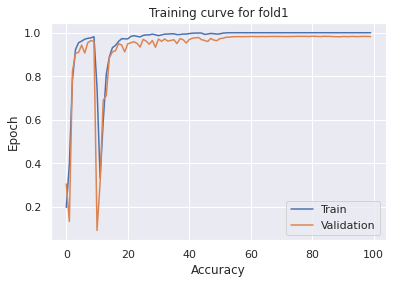

Epoch=0, Train loss=1.64829, Valid loss=1.94092, Train Accuracy=0.49583, Validation Accuracy=0.55069
Epoch=10, Train loss=0.04334, Valid loss=0.24457, Train Accuracy=0.98639, Validation Accuracy=0.94238
Epoch=20, Train loss=0.03014, Valid loss=0.14301, Train Accuracy=0.99016, Validation Accuracy=0.96379
Epoch=30, Train loss=0.02596, Valid loss=0.13547, Train Accuracy=0.99245, Validation Accuracy=0.96914
Epoch=40, Train loss=0.00886, Valid loss=0.11575, Train Accuracy=0.99725, Validation Accuracy=0.97450
Epoch=50, Train loss=0.00301, Valid loss=0.10127, Train Accuracy=0.99913, Validation Accuracy=0.98016
Epoch=60, Train loss=0.00092, Valid loss=0.08211, Train Accuracy=0.99976, Validation Accuracy=0.98174
Epoch=70, Train loss=0.00001, Valid loss=0.08165, Train Accuracy=1.00000, Validation Accuracy=0.98457
Epoch=80, Train loss=0.00001, Valid loss=0.08187, Train Accuracy=1.00000, Validation Accuracy=0.98426
Epoch=90, Train loss=0.00001, Valid loss=0.08185, Train Accuracy=1.00000, Validatio

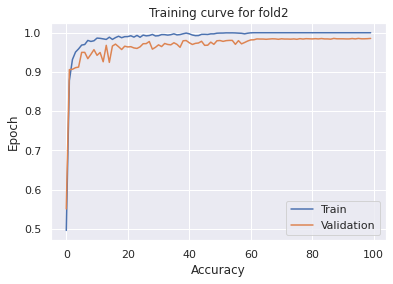

Epoch=0, Train loss=2.71140, Valid loss=318.91910, Train Accuracy=0.17904, Validation Accuracy=0.09852
Epoch=10, Train loss=0.04831, Valid loss=0.11422, Train Accuracy=0.98442, Validation Accuracy=0.96789
Epoch=20, Train loss=0.02963, Valid loss=0.12847, Train Accuracy=0.99142, Validation Accuracy=0.96506
Epoch=30, Train loss=0.02599, Valid loss=0.11936, Train Accuracy=0.99229, Validation Accuracy=0.97199
Epoch=40, Train loss=0.02763, Valid loss=0.10508, Train Accuracy=0.99064, Validation Accuracy=0.97041
Epoch=50, Train loss=0.00823, Valid loss=0.07105, Train Accuracy=0.99788, Validation Accuracy=0.98269
Epoch=60, Train loss=0.00003, Valid loss=0.05671, Train Accuracy=1.00000, Validation Accuracy=0.98741
Epoch=70, Train loss=0.00002, Valid loss=0.05600, Train Accuracy=1.00000, Validation Accuracy=0.98709
Epoch=80, Train loss=0.00002, Valid loss=0.05628, Train Accuracy=1.00000, Validation Accuracy=0.98772
Epoch=90, Train loss=0.00002, Valid loss=0.05651, Train Accuracy=1.00000, Validat

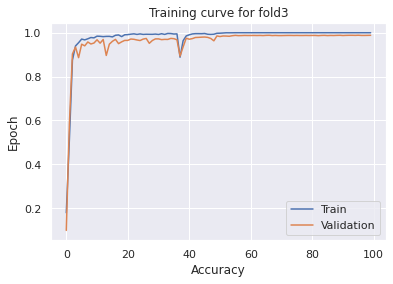

Epoch=0, Train loss=2.62454, Valid loss=64.18946, Train Accuracy=0.23420, Validation Accuracy=0.08908
Epoch=10, Train loss=0.04333, Valid loss=0.12113, Train Accuracy=0.98631, Validation Accuracy=0.96475
Epoch=20, Train loss=0.02227, Valid loss=0.10065, Train Accuracy=0.99245, Validation Accuracy=0.97262
Epoch=30, Train loss=0.02107, Valid loss=0.12164, Train Accuracy=0.99323, Validation Accuracy=0.97387
Epoch=40, Train loss=0.00539, Valid loss=0.08482, Train Accuracy=0.99803, Validation Accuracy=0.97954
Epoch=50, Train loss=0.00285, Valid loss=0.08880, Train Accuracy=0.99913, Validation Accuracy=0.97891
Epoch=60, Train loss=0.00247, Valid loss=0.07354, Train Accuracy=0.99921, Validation Accuracy=0.98363
Epoch=70, Train loss=0.00012, Valid loss=0.07143, Train Accuracy=1.00000, Validation Accuracy=0.98489
Epoch=80, Train loss=0.00004, Valid loss=0.06903, Train Accuracy=1.00000, Validation Accuracy=0.98521
Epoch=90, Train loss=0.00003, Valid loss=0.06863, Train Accuracy=1.00000, Validati

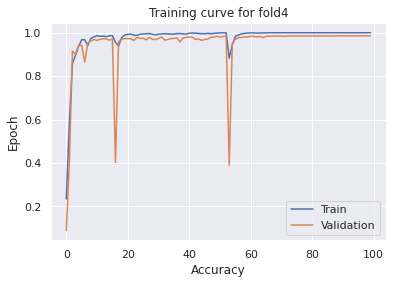

CV Accuracy Score=0.9855829765802065


In [11]:
# Training Parameters
lr = 0.1
epochs = 100
model_name = "resnet34"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=False)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

#### ResNet50

Epoch=0, Train loss=7.26148, Valid loss=228.73491, Train Accuracy=0.10356, Validation Accuracy=0.12213
Epoch=10, Train loss=0.57719, Valid loss=0.26730, Train Accuracy=0.97710, Validation Accuracy=0.93925
Epoch=20, Train loss=0.52212, Valid loss=0.24488, Train Accuracy=0.99213, Validation Accuracy=0.94901
Epoch=30, Train loss=0.51631, Valid loss=0.20128, Train Accuracy=0.99418, Validation Accuracy=0.96443
Epoch=40, Train loss=0.50700, Valid loss=0.21512, Train Accuracy=0.99732, Validation Accuracy=0.96191
Epoch=50, Train loss=0.51159, Valid loss=0.18000, Train Accuracy=0.99591, Validation Accuracy=0.97041
Epoch=60, Train loss=0.50058, Valid loss=0.15004, Train Accuracy=1.00000, Validation Accuracy=0.98395
Epoch=70, Train loss=0.50046, Valid loss=0.14693, Train Accuracy=1.00000, Validation Accuracy=0.98363
Epoch=80, Train loss=0.50038, Valid loss=0.14636, Train Accuracy=1.00000, Validation Accuracy=0.98395
Epoch=90, Train loss=0.50036, Valid loss=0.14645, Train Accuracy=1.00000, Validat

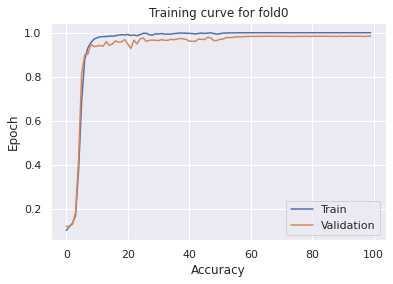

Epoch=0, Train loss=5.53529, Valid loss=316.29223, Train Accuracy=0.10065, Validation Accuracy=0.10482
Epoch=10, Train loss=0.55580, Valid loss=0.27708, Train Accuracy=0.97922, Validation Accuracy=0.94145
Epoch=20, Train loss=0.51709, Valid loss=0.18571, Train Accuracy=0.99481, Validation Accuracy=0.96789
Epoch=30, Train loss=0.51566, Valid loss=0.19303, Train Accuracy=0.99488, Validation Accuracy=0.96569
Epoch=40, Train loss=0.50613, Valid loss=0.19162, Train Accuracy=0.99764, Validation Accuracy=0.96884
Epoch=50, Train loss=0.50223, Valid loss=0.15351, Train Accuracy=0.99937, Validation Accuracy=0.98017
Epoch=60, Train loss=0.50042, Valid loss=0.14447, Train Accuracy=1.00000, Validation Accuracy=0.98269
Epoch=70, Train loss=0.50038, Valid loss=0.14407, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=80, Train loss=0.50035, Valid loss=0.14258, Train Accuracy=1.00000, Validation Accuracy=0.98269
Epoch=90, Train loss=0.50034, Valid loss=0.14391, Train Accuracy=1.00000, Validat

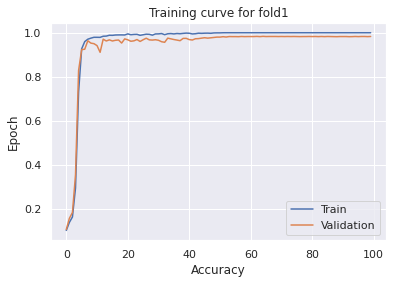

Epoch=0, Train loss=5.63020, Valid loss=1587.56788, Train Accuracy=0.10112, Validation Accuracy=0.11555
Epoch=10, Train loss=0.55842, Valid loss=0.25658, Train Accuracy=0.97805, Validation Accuracy=0.95025
Epoch=20, Train loss=0.53607, Valid loss=0.26105, Train Accuracy=0.98796, Validation Accuracy=0.94332
Epoch=30, Train loss=0.52085, Valid loss=0.20385, Train Accuracy=0.99323, Validation Accuracy=0.96946
Epoch=40, Train loss=0.50645, Valid loss=0.19722, Train Accuracy=0.99819, Validation Accuracy=0.96568
Epoch=50, Train loss=0.50704, Valid loss=0.14613, Train Accuracy=0.99811, Validation Accuracy=0.98111
Epoch=60, Train loss=0.50221, Valid loss=0.15869, Train Accuracy=0.99953, Validation Accuracy=0.98048
Epoch=70, Train loss=0.50041, Valid loss=0.15472, Train Accuracy=1.00000, Validation Accuracy=0.98237
Epoch=80, Train loss=0.50037, Valid loss=0.15447, Train Accuracy=1.00000, Validation Accuracy=0.98205
Epoch=90, Train loss=0.50036, Valid loss=0.15359, Train Accuracy=1.00000, Valida

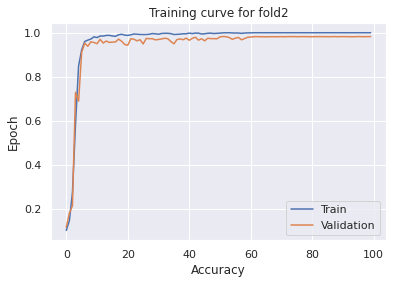

Epoch=0, Train loss=7.40592, Valid loss=1395.78667, Train Accuracy=0.10498, Validation Accuracy=0.08562
Epoch=10, Train loss=0.60092, Valid loss=0.20720, Train Accuracy=0.96648, Validation Accuracy=0.95751
Epoch=20, Train loss=0.52502, Valid loss=0.19150, Train Accuracy=0.99252, Validation Accuracy=0.96758
Epoch=30, Train loss=0.51869, Valid loss=0.18192, Train Accuracy=0.99426, Validation Accuracy=0.97199
Epoch=40, Train loss=0.51955, Valid loss=0.17810, Train Accuracy=0.99378, Validation Accuracy=0.97387
Epoch=50, Train loss=0.50648, Valid loss=0.18085, Train Accuracy=0.99835, Validation Accuracy=0.97230
Epoch=60, Train loss=0.50218, Valid loss=0.17415, Train Accuracy=0.99961, Validation Accuracy=0.97262
Epoch=70, Train loss=0.50049, Valid loss=0.13973, Train Accuracy=1.00000, Validation Accuracy=0.98363
Epoch=80, Train loss=0.50045, Valid loss=0.13996, Train Accuracy=1.00000, Validation Accuracy=0.98395
Epoch=90, Train loss=0.50041, Valid loss=0.14065, Train Accuracy=1.00000, Valida

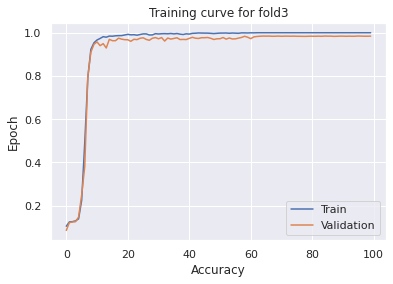

Epoch=0, Train loss=6.27909, Valid loss=188211.92935, Train Accuracy=0.10356, Validation Accuracy=0.10041
Epoch=10, Train loss=0.57196, Valid loss=0.22952, Train Accuracy=0.97505, Validation Accuracy=0.95373
Epoch=20, Train loss=0.53134, Valid loss=0.19131, Train Accuracy=0.98993, Validation Accuracy=0.97136
Epoch=30, Train loss=0.51821, Valid loss=0.16021, Train Accuracy=0.99426, Validation Accuracy=0.97545
Epoch=40, Train loss=0.51290, Valid loss=0.16227, Train Accuracy=0.99567, Validation Accuracy=0.97923
Epoch=50, Train loss=0.50183, Valid loss=0.14484, Train Accuracy=0.99961, Validation Accuracy=0.98332
Epoch=60, Train loss=0.51065, Valid loss=0.16755, Train Accuracy=0.99662, Validation Accuracy=0.97545
Epoch=70, Train loss=0.50049, Valid loss=0.13405, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=80, Train loss=0.50043, Valid loss=0.13474, Train Accuracy=1.00000, Validation Accuracy=0.98709
Epoch=90, Train loss=0.50039, Valid loss=0.13289, Train Accuracy=1.00000, Vali

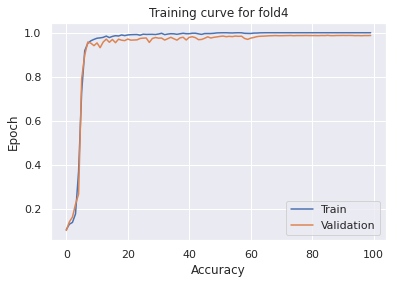

CV Accuracy Score=0.9844497607655502


In [12]:
# Training Parameters
lr = 0.1
epochs = 100
model_name = "resnet50"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [14]:
gc.collect()
torch.cuda.empty_cache()

### EfficientNet

#### EfficientNet-B0

##### Vanilla

Epoch=0, Train loss=1.61041, Valid loss=2.26705, Train Accuracy=0.52302, Validation Accuracy=0.59647
Epoch=10, Train loss=0.59661, Valid loss=0.25258, Train Accuracy=0.96907, Validation Accuracy=0.94492
Epoch=20, Train loss=0.57053, Valid loss=0.22807, Train Accuracy=0.97962, Validation Accuracy=0.95121
Epoch=30, Train loss=0.53164, Valid loss=0.20910, Train Accuracy=0.99071, Validation Accuracy=0.96254
Epoch=40, Train loss=0.51161, Valid loss=0.17099, Train Accuracy=0.99740, Validation Accuracy=0.97387
Epoch=50, Train loss=0.50290, Valid loss=0.13656, Train Accuracy=1.00000, Validation Accuracy=0.98678
Epoch=60, Train loss=0.50265, Valid loss=0.13612, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=70, Train loss=0.50243, Valid loss=0.13642, Train Accuracy=1.00000, Validation Accuracy=0.98584
Epoch=80, Train loss=0.50219, Valid loss=0.13788, Train Accuracy=1.00000, Validation Accuracy=0.98678
Epoch=90, Train loss=0.50208, Valid loss=0.13706, Train Accuracy=1.00000, Validatio

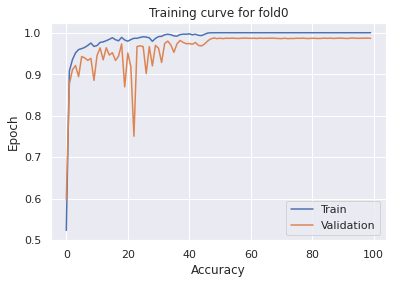

Epoch=0, Train loss=1.63632, Valid loss=1.48842, Train Accuracy=0.51971, Validation Accuracy=0.62795
Epoch=10, Train loss=0.57112, Valid loss=0.21420, Train Accuracy=0.97749, Validation Accuracy=0.96286
Epoch=20, Train loss=0.55085, Valid loss=0.25053, Train Accuracy=0.98544, Validation Accuracy=0.94932
Epoch=30, Train loss=0.52975, Valid loss=0.29576, Train Accuracy=0.99245, Validation Accuracy=0.93138
Epoch=40, Train loss=0.52003, Valid loss=0.19835, Train Accuracy=0.99488, Validation Accuracy=0.96569
Epoch=50, Train loss=0.50659, Valid loss=0.18852, Train Accuracy=0.99906, Validation Accuracy=0.97199
Epoch=60, Train loss=0.50273, Valid loss=0.13304, Train Accuracy=1.00000, Validation Accuracy=0.98709
Epoch=70, Train loss=0.50240, Valid loss=0.13205, Train Accuracy=1.00000, Validation Accuracy=0.98867
Epoch=80, Train loss=0.50222, Valid loss=0.13214, Train Accuracy=1.00000, Validation Accuracy=0.98804
Epoch=90, Train loss=0.50204, Valid loss=0.13166, Train Accuracy=1.00000, Validatio

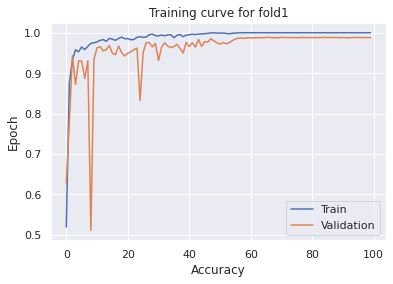

Epoch=0, Train loss=1.71028, Valid loss=34.28002, Train Accuracy=0.47954, Validation Accuracy=0.22670
Epoch=10, Train loss=0.57332, Valid loss=0.20827, Train Accuracy=0.97521, Validation Accuracy=0.95435
Epoch=20, Train loss=0.55053, Valid loss=0.27222, Train Accuracy=0.98466, Validation Accuracy=0.94270
Epoch=30, Train loss=0.53351, Valid loss=0.17040, Train Accuracy=0.99056, Validation Accuracy=0.97418
Epoch=40, Train loss=0.52083, Valid loss=0.19681, Train Accuracy=0.99559, Validation Accuracy=0.96631
Epoch=50, Train loss=0.52231, Valid loss=0.15931, Train Accuracy=0.99441, Validation Accuracy=0.97859
Epoch=60, Train loss=0.50278, Valid loss=0.14355, Train Accuracy=1.00000, Validation Accuracy=0.98457
Epoch=70, Train loss=0.50245, Valid loss=0.14057, Train Accuracy=1.00000, Validation Accuracy=0.98489
Epoch=80, Train loss=0.50221, Valid loss=0.14083, Train Accuracy=1.00000, Validation Accuracy=0.98520
Epoch=90, Train loss=0.50209, Valid loss=0.14213, Train Accuracy=1.00000, Validati

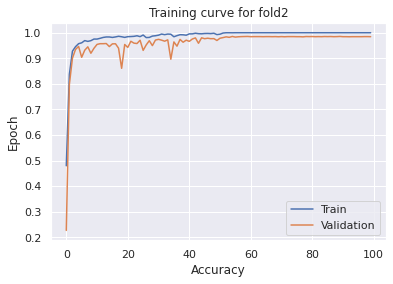

Epoch=0, Train loss=1.53978, Valid loss=3.18683, Train Accuracy=0.55843, Validation Accuracy=0.49103
Epoch=10, Train loss=0.56346, Valid loss=0.31328, Train Accuracy=0.97875, Validation Accuracy=0.92383
Epoch=20, Train loss=0.55042, Valid loss=0.21719, Train Accuracy=0.98473, Validation Accuracy=0.95877
Epoch=30, Train loss=0.52682, Valid loss=0.16762, Train Accuracy=0.99402, Validation Accuracy=0.97104
Epoch=40, Train loss=0.51547, Valid loss=0.15994, Train Accuracy=0.99607, Validation Accuracy=0.97576
Epoch=50, Train loss=0.51090, Valid loss=0.15851, Train Accuracy=0.99843, Validation Accuracy=0.97860
Epoch=60, Train loss=0.50568, Valid loss=0.14586, Train Accuracy=0.99898, Validation Accuracy=0.98206
Epoch=70, Train loss=0.50237, Valid loss=0.14294, Train Accuracy=1.00000, Validation Accuracy=0.98678
Epoch=80, Train loss=0.50222, Valid loss=0.14004, Train Accuracy=1.00000, Validation Accuracy=0.98615
Epoch=90, Train loss=0.50217, Valid loss=0.14327, Train Accuracy=1.00000, Validatio

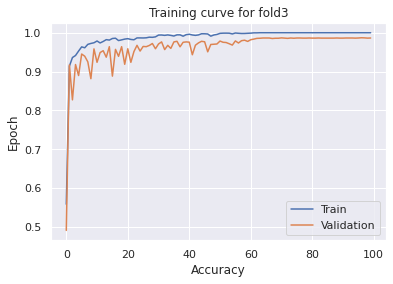

Epoch=0, Train loss=1.55200, Valid loss=1.42870, Train Accuracy=0.54112, Validation Accuracy=0.65817
Epoch=10, Train loss=0.57763, Valid loss=0.30063, Train Accuracy=0.97316, Validation Accuracy=0.93233
Epoch=20, Train loss=0.55396, Valid loss=0.31899, Train Accuracy=0.98465, Validation Accuracy=0.92414
Epoch=30, Train loss=0.52949, Valid loss=0.16926, Train Accuracy=0.99315, Validation Accuracy=0.97356
Epoch=40, Train loss=0.50742, Valid loss=0.15876, Train Accuracy=0.99906, Validation Accuracy=0.98048
Epoch=50, Train loss=0.51142, Valid loss=0.23920, Train Accuracy=0.99717, Validation Accuracy=0.95121
Epoch=60, Train loss=0.50261, Valid loss=0.13510, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=70, Train loss=0.50257, Valid loss=0.13427, Train Accuracy=1.00000, Validation Accuracy=0.98741
Epoch=80, Train loss=0.50228, Valid loss=0.13363, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=90, Train loss=0.50216, Valid loss=0.13274, Train Accuracy=1.00000, Validatio

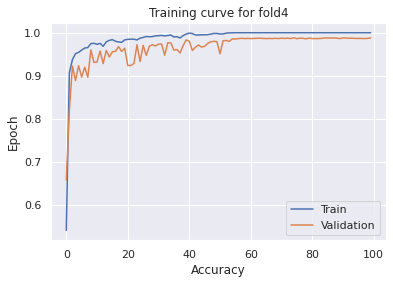

CV Accuracy Score=0.9867161923948627


In [17]:
lr = 0.1
epochs = 100
model_name = "efficientnet-b0"
optim_name = "radam"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [18]:
gc.collect()
torch.cuda.empty_cache()

##### SWA

../src/radam.py:84: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  p_data_fp32.addcdiv_(-step_size, exp_avg, denom)


Epoch=0, Accuracy=0.7784073024866226
Epoch=10, Accuracy=0.9483789738747246
Epoch=20, Accuracy=0.9631728045325779
Epoch=30, Accuracy=0.9628580421781555
Epoch=40, Accuracy=0.9773371104815864
Epoch=50, Accuracy=0.9723009128108279
Epoch=60, Accuracy=0.9719861504564055
Epoch=70, Accuracy=0.9723009128108279
Epoch=80, Accuracy=0.9571923197985521
Epoch=90, Accuracy=0.9833175952156122
Epoch=100, Accuracy=0.9842618822788795
Epoch=110, Accuracy=0.983947119924457
Epoch=120, Accuracy=0.9845766446333019
Epoch=130, Accuracy=0.9848914069877243
Epoch=140, Accuracy=0.9848914069877243
Epoch=150, Accuracy=0.9845766446333019
Epoch=160, Accuracy=0.9845766446333019
Fold=0, Validation Accuracy=0.9845766446333019


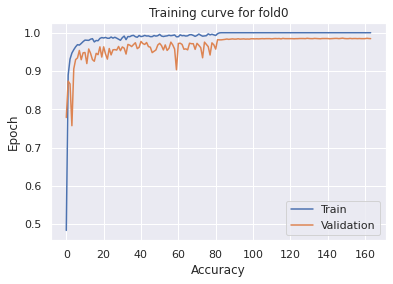

UnboundLocalError: local variable 'model' referenced before assignment

In [8]:
lr = 0.03
epochs = 164
model = models.EfficientNetB0()
model_name = "efficientnet-b0"
optimizer = RAdam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[81, 122], gamma=0.1)
checkpoint = f"./checkpoints/swa-efficientnet-b0-radam{lr}"

oof, targs = run(model, model_name, optimizer, scheduler, epochs, lr, checkpoint, swa=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# EfficientNet-B0
EPOCHS = 164
oof_effnb0 = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=True)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=768)

    model = models.EfficientNetB0().to(device)

    lr = 0.03
    optimizer = RAdam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[81, 122], gamma=0.1)
    scaler = torch.cuda.amp.GradScaler()
    
    swa_start = int(0.75 * EPOCHS)
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=lr * (0.1)**2)
    
    train_accuracies = []
    valid_accuracies = []
    checkpoint = "./checkpoints/efficientnet-b0-radam003"
    best_accuracy = 0
    
    for epoch in range(EPOCHS):
        
        # Train
        train_loss, train_accuracy = engine.train(train_loader, model, optimizer, device, scaler)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        valid_preds, valid_targs = engine.evaluate(valid_loader, model, device)
        valid_preds = np.argmax(valid_preds, axis=1)
        valid_accuracy = metrics.accuracy_score(valid_targs, valid_preds)
        valid_accuracies.append(valid_accuracy)
        
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")
        
        # Checkpoint
        is_best = best_accuracy > best_accuracy
        if is_best:
            best_accuracy = valid_accuracy
        save_checkpoint({
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "swa_state_dict": swa_model.state_dict(),
            "acc": valid_accuracy,
            "best_acc": best_accuracy,
            "optimizer": optimizer.state_dict(),
            }, is_best, checkpoint)

    # Update BN stats
    swa_model = swa_model.cpu()
    update_bn(train_loader, swa_model)
    swa_model.to(device)
            
    # Validation
    probs, targs = engine.evaluate(valid_loader, swa_model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()
    
    oof_effnb0[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(swa_model.state_dict(), f"../models/swa-efficientnet-b0-{fold}.pth")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()

np.save("../input/processed/oof-train-swa-efficientnet-b0", oof_effnb0)

#### EfficientNet-B1

Epoch=0, Train loss=2.05949, Valid loss=2.31869, Train Accuracy=0.27607, Validation Accuracy=0.08908
Epoch=10, Train loss=0.10645, Valid loss=4.56958, Train Accuracy=0.97017, Validation Accuracy=0.80107
Epoch=20, Train loss=0.08573, Valid loss=0.28340, Train Accuracy=0.97033, Validation Accuracy=0.93359
Epoch=30, Train loss=0.03278, Valid loss=0.54056, Train Accuracy=0.98906, Validation Accuracy=0.90400
Epoch=40, Train loss=0.01194, Valid loss=0.12083, Train Accuracy=0.99638, Validation Accuracy=0.97450
Epoch=50, Train loss=0.00942, Valid loss=0.10354, Train Accuracy=0.99693, Validation Accuracy=0.97828
Epoch=60, Train loss=0.00900, Valid loss=0.13365, Train Accuracy=0.99748, Validation Accuracy=0.97073
Epoch=70, Train loss=0.00028, Valid loss=0.08048, Train Accuracy=0.99992, Validation Accuracy=0.98206
Epoch=80, Train loss=0.00017, Valid loss=0.08441, Train Accuracy=1.00000, Validation Accuracy=0.98237
Epoch=90, Train loss=0.00023, Valid loss=0.08063, Train Accuracy=0.99992, Validatio

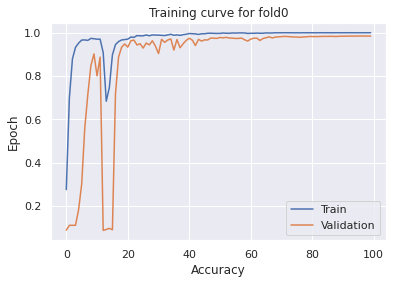

Epoch=0, Train loss=2.08967, Valid loss=2.31685, Train Accuracy=0.27095, Validation Accuracy=0.10733
Epoch=10, Train loss=0.10647, Valid loss=28.21428, Train Accuracy=0.96876, Validation Accuracy=0.83129
Epoch=20, Train loss=0.03936, Valid loss=0.15458, Train Accuracy=0.98764, Validation Accuracy=0.96789
Epoch=30, Train loss=0.05657, Valid loss=0.16156, Train Accuracy=0.98229, Validation Accuracy=0.96632
Epoch=40, Train loss=0.02371, Valid loss=0.24115, Train Accuracy=0.99292, Validation Accuracy=0.95121
Epoch=50, Train loss=0.00586, Valid loss=0.08809, Train Accuracy=0.99795, Validation Accuracy=0.97860
Epoch=60, Train loss=0.00460, Valid loss=0.10233, Train Accuracy=0.99835, Validation Accuracy=0.97576
Epoch=70, Train loss=0.00144, Valid loss=0.07929, Train Accuracy=0.99976, Validation Accuracy=0.98237
Epoch=80, Train loss=0.00036, Valid loss=0.07355, Train Accuracy=0.99992, Validation Accuracy=0.98458
Epoch=90, Train loss=0.00005, Valid loss=0.07048, Train Accuracy=1.00000, Validati

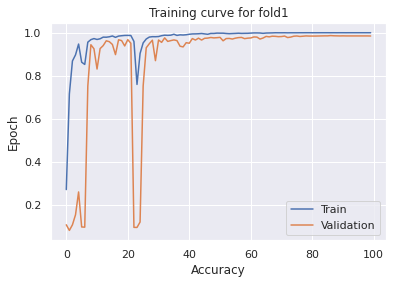

Epoch=0, Train loss=1.97368, Valid loss=2.33702, Train Accuracy=0.30556, Validation Accuracy=0.07746
Epoch=10, Train loss=0.06149, Valid loss=0.52293, Train Accuracy=0.98009, Validation Accuracy=0.92034
Epoch=20, Train loss=1.17928, Valid loss=15.18341, Train Accuracy=0.56020, Validation Accuracy=0.26196
Epoch=30, Train loss=0.06845, Valid loss=0.21657, Train Accuracy=0.97726, Validation Accuracy=0.94616
Epoch=40, Train loss=0.03351, Valid loss=0.14105, Train Accuracy=0.98914, Validation Accuracy=0.96788
Epoch=50, Train loss=0.02148, Valid loss=0.15759, Train Accuracy=0.99300, Validation Accuracy=0.96505
Epoch=60, Train loss=0.00998, Valid loss=0.17597, Train Accuracy=0.99638, Validation Accuracy=0.96379
Epoch=70, Train loss=0.00121, Valid loss=0.09265, Train Accuracy=0.99961, Validation Accuracy=0.97922
Epoch=80, Train loss=0.00086, Valid loss=0.10192, Train Accuracy=0.99961, Validation Accuracy=0.97985
Epoch=90, Train loss=0.00014, Valid loss=0.09892, Train Accuracy=1.00000, Validati

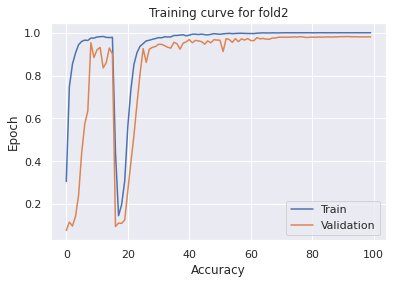

Epoch=0, Train loss=1.99915, Valid loss=2.33480, Train Accuracy=0.29409, Validation Accuracy=0.09632
Epoch=10, Train loss=0.13575, Valid loss=0.53783, Train Accuracy=0.95506, Validation Accuracy=0.88196
Epoch=20, Train loss=0.04158, Valid loss=0.29805, Train Accuracy=0.98536, Validation Accuracy=0.94208
Epoch=30, Train loss=0.03372, Valid loss=0.24830, Train Accuracy=0.98859, Validation Accuracy=0.95404
Epoch=40, Train loss=0.02140, Valid loss=0.13316, Train Accuracy=0.99245, Validation Accuracy=0.97230
Epoch=50, Train loss=0.00781, Valid loss=0.12400, Train Accuracy=0.99764, Validation Accuracy=0.97482
Epoch=60, Train loss=0.00598, Valid loss=0.10895, Train Accuracy=0.99827, Validation Accuracy=0.97639
Epoch=70, Train loss=0.00031, Valid loss=0.07185, Train Accuracy=1.00000, Validation Accuracy=0.98615
Epoch=80, Train loss=0.00035, Valid loss=0.08557, Train Accuracy=0.99992, Validation Accuracy=0.98300
Epoch=90, Train loss=0.00015, Valid loss=0.07325, Train Accuracy=0.99992, Validatio

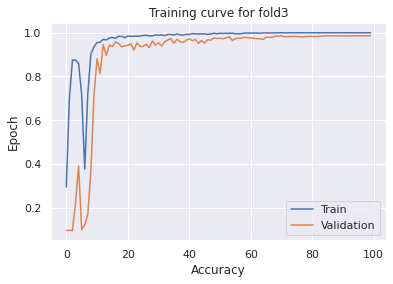

Epoch=0, Train loss=1.97647, Valid loss=2.33676, Train Accuracy=0.29740, Validation Accuracy=0.09128
Epoch=10, Train loss=0.07780, Valid loss=0.37589, Train Accuracy=0.97600, Validation Accuracy=0.93736
Epoch=20, Train loss=0.90351, Valid loss=6.62962, Train Accuracy=0.70229, Validation Accuracy=0.43846
Epoch=30, Train loss=0.16545, Valid loss=0.55850, Train Accuracy=0.94531, Validation Accuracy=0.87504
Epoch=40, Train loss=0.03773, Valid loss=0.18421, Train Accuracy=0.98843, Validation Accuracy=0.95562
Epoch=50, Train loss=0.02074, Valid loss=0.18820, Train Accuracy=0.99323, Validation Accuracy=0.95940
Epoch=60, Train loss=0.00513, Valid loss=0.12042, Train Accuracy=0.99788, Validation Accuracy=0.97702
Epoch=70, Train loss=0.00455, Valid loss=0.14944, Train Accuracy=0.99890, Validation Accuracy=0.96852
Epoch=80, Train loss=0.00091, Valid loss=0.13805, Train Accuracy=0.99961, Validation Accuracy=0.97671
Epoch=90, Train loss=0.00112, Valid loss=0.13429, Train Accuracy=0.99976, Validatio

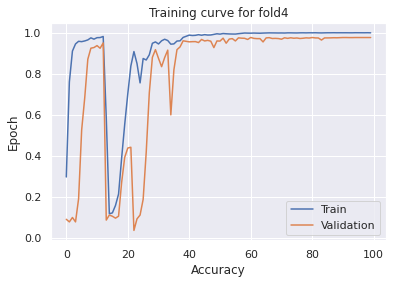

CV Accuracy Score=0.9826240241752707


In [32]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b1"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [34]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B2

In [ ]:
lr = 0.03
epochs = 100
model_name = "efficientnet-b2"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B3

In [38]:
lr = 0.03
epochs = 100
model_name = "efficientnet-b3"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

RuntimeError: running_mean should contain 32 elements not 40

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B4

Epoch=0, Train loss=2.18753, Valid loss=2.30316, Train Accuracy=0.21783, Validation Accuracy=0.09726
Epoch=10, Train loss=0.08496, Valid loss=0.21587, Train Accuracy=0.97553, Validation Accuracy=0.94995
Epoch=20, Train loss=0.04487, Valid loss=0.20196, Train Accuracy=0.98717, Validation Accuracy=0.96003
Epoch=30, Train loss=0.01561, Valid loss=0.15455, Train Accuracy=0.99559, Validation Accuracy=0.96695
Epoch=40, Train loss=0.02628, Valid loss=0.14747, Train Accuracy=0.99197, Validation Accuracy=0.96947
Epoch=50, Train loss=0.01306, Valid loss=0.07946, Train Accuracy=0.99638, Validation Accuracy=0.98048
Epoch=60, Train loss=0.01338, Valid loss=0.10168, Train Accuracy=0.99709, Validation Accuracy=0.97734
Epoch=70, Train loss=0.00017, Valid loss=0.07631, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=80, Train loss=0.00016, Valid loss=0.08743, Train Accuracy=0.99992, Validation Accuracy=0.98332
Epoch=90, Train loss=0.00035, Valid loss=0.08704, Train Accuracy=0.99984, Validatio

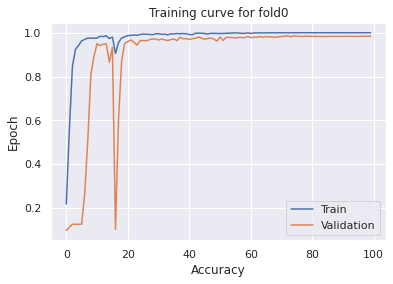

Epoch=0, Train loss=2.26633, Valid loss=2.30193, Train Accuracy=0.18439, Validation Accuracy=0.12024


In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b4"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [16]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B5

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b5"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B6

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b6"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [8]:
torch.cuda.empty_cache()
gc.collect()

29

#### EfficientNet-B7

In [23]:
lr = 0.03
epochs = 100
model_name = "efficientnet-b7"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [24]:
torch.cuda.empty_cache()
gc.collect()

Epoch=0, Accuracy=0.11142587346553352
Epoch=10, Accuracy=0.08781869688385269
Epoch=20, Accuracy=0.08781869688385269
Epoch=30, Accuracy=0.11740635819955933
Epoch=40, Accuracy=0.09977966635190431
Epoch=50, Accuracy=0.1252754170601196
Epoch=60, Accuracy=0.10324205225055083
Epoch=70, Accuracy=0.11268492288322317
Epoch=80, Accuracy=0.1022977651872836
Epoch=90, Accuracy=0.12590494176896444
Epoch=100, Accuracy=0.1252754170601196
Epoch=110, Accuracy=0.1252754170601196
Epoch=120, Accuracy=0.12653446647780925
Epoch=130, Accuracy=0.1252754170601196
Epoch=140, Accuracy=0.1252754170601196
Epoch=150, Accuracy=0.1252754170601196
Epoch=160, Accuracy=0.1252754170601196
Epoch=170, Accuracy=0.1252754170601196


KeyboardInterrupt: 

#### EfficientNet-B8

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b8"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [32]:
torch.cuda.empty_cache()
gc.collect()

2914

#### EfficientNet-L2

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-l2"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

## Inference

In [14]:
df_test = pd.read_csv("../input/test.csv")

In [15]:
probs_test = np.zeros((len(df_test), 10))

### 1-input channel models

In [ ]:
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

In [ ]:
# model = models.Model()
# swa_model = AveragedModel(model)
# swa_model.load_state_dict(torch.load("../models/baseline-swa-4.pth"))
# swa_model.to(device)
# probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

In [ ]:
model = models.SpinalVGG()
swa_model = AveragedModel(model)
swa_model.load_state_dict(torch.load("../models/spinalvgg-swa-0.pth"))
swa_model.to(device)
probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

### 3-input channel models

In [16]:
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False, rgb=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

In [ ]:
model = ResNet18()
# swa_model = AveragedModel(model)
model.load_state_dict(torch.load("../models/resnet18-1.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

In [ ]:
model = ResNet34()
# swa_model = AveragedModel(model)
model.load_state_dict(torch.load("../models/resnet34-4.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

#### EfficientNet-B0

##### Vanilla

In [19]:
model = models.EfficientNetB0()
model.load_state_dict(torch.load("../models/efficientnet-b0-4.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

##### SWA

In [17]:
model = models.EfficientNetB0()
swa_model = AveragedModel(model)
swa_model.load_state_dict(torch.load("../models/swa-efficientnet-b0-4.pth"))
swa_model.to(device)
probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

### Submission

In [18]:
preds_test = np.argmax(probs_test, axis=1)

In [19]:
submission = pd.DataFrame({"id": df_test.id, "digit": preds_test})
submission.to_csv("../output/swa-efficientnetb0_radam003.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
